Project Goal: To predict if a customer will subscribe to a Term Deposit and segment customers for targeted marketing strategies. Key Techniques: Random Forest, K-Means Clustering, SMOTE (for imbalance), Streamlit Deployment. Outcome: Achieved 88% Accuracy and identified 4 distinct customer personas.

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans  # For Customer Segmentation
from sklearn.decomposition import PCA # For Visualization
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

print("Libraries Imported Successfully!")

In [ ]:
# Loading Dataset
data = pd.read_csv('bank_marketing.csv')
print("Data Shape:", data.shape)
data.head()

In [ ]:
# Data Cleaning & Handling Missing Values
# 1. Dropping 'duration' to prevent Data Leakage
# Reason: 'duration' is only known after the call is made. Using it for prediction is cheating.
if 'duration' in data.columns:
    data = data.drop('duration', axis=1)
    print(" 'duration' column dropped (Prevented Data Leakage).")

# 2. Handling Missing Values
# In bank data, missing values in categorical columns often mean 'Unknown'
categorical_cols_missing = ['job', 'education', 'contact', 'poutcome']
for col in categorical_cols_missing:
    data[col].fillna('unknown', inplace=True)

# 3. Removing Duplicates
initial_rows = data.shape[0]
data.drop_duplicates(inplace=True)
print(f"Duplicates removed: {initial_rows - data.shape[0]} rows.")

# Checking for remaining missing values
print("Missing Values Check:")
print(data.isnull().sum().sum())

In [ ]:
#  Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='subscribe', data=data, palette='viridis')
plt.title('Target Variable Distribution (Subscribe)')
plt.show()

# Printing percentages
print(data['subscribe'].value_counts(normalize=True) * 100)

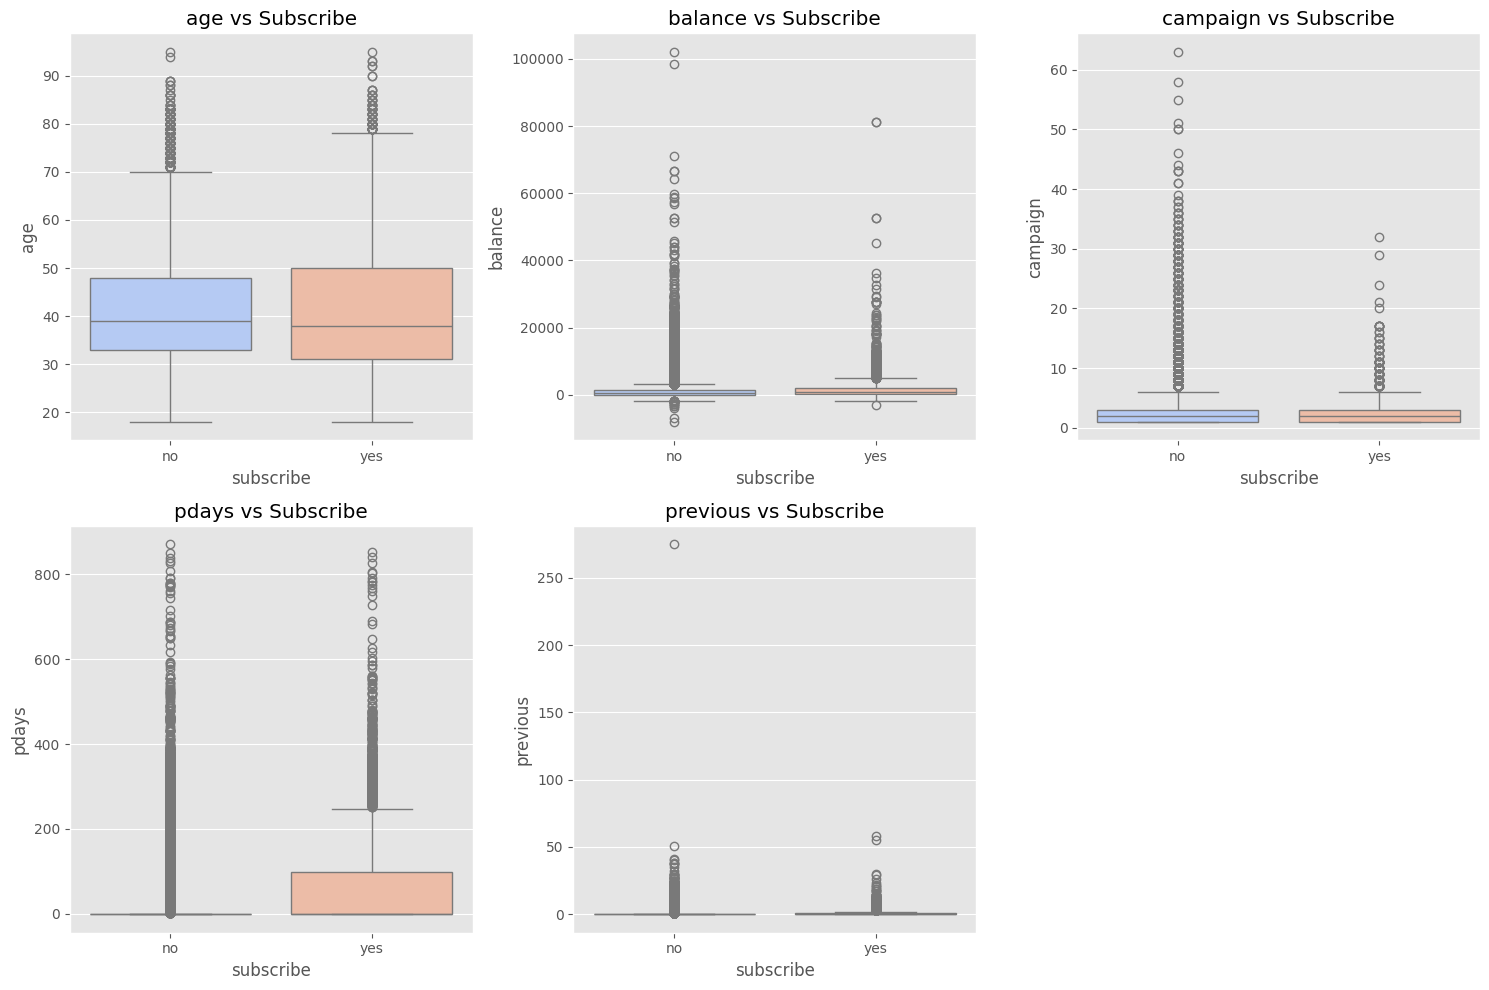

Average Balance of Subscribers: $1804.27
Average Balance of Non-Subscribers: $1304.24


In [5]:
# Visualize Numerical Features vs Target
numeric_cols = ['age', 'balance', 'campaign', 'pdays', 'previous']

# Plotting Boxplots to see distribution
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='subscribe', y=col, data=data, palette='coolwarm')
    plt.title(f'{col} vs Subscribe')
plt.tight_layout()
plt.show()

# Insight Calculation
avg_balance_yes = data[data['subscribe']=='yes']['balance'].mean()
avg_balance_no = data[data['subscribe']=='no']['balance'].mean()
print(f"Average Balance of Subscribers: ${avg_balance_yes:.2f}")
print(f"Average Balance of Non-Subscribers: ${avg_balance_no:.2f}")

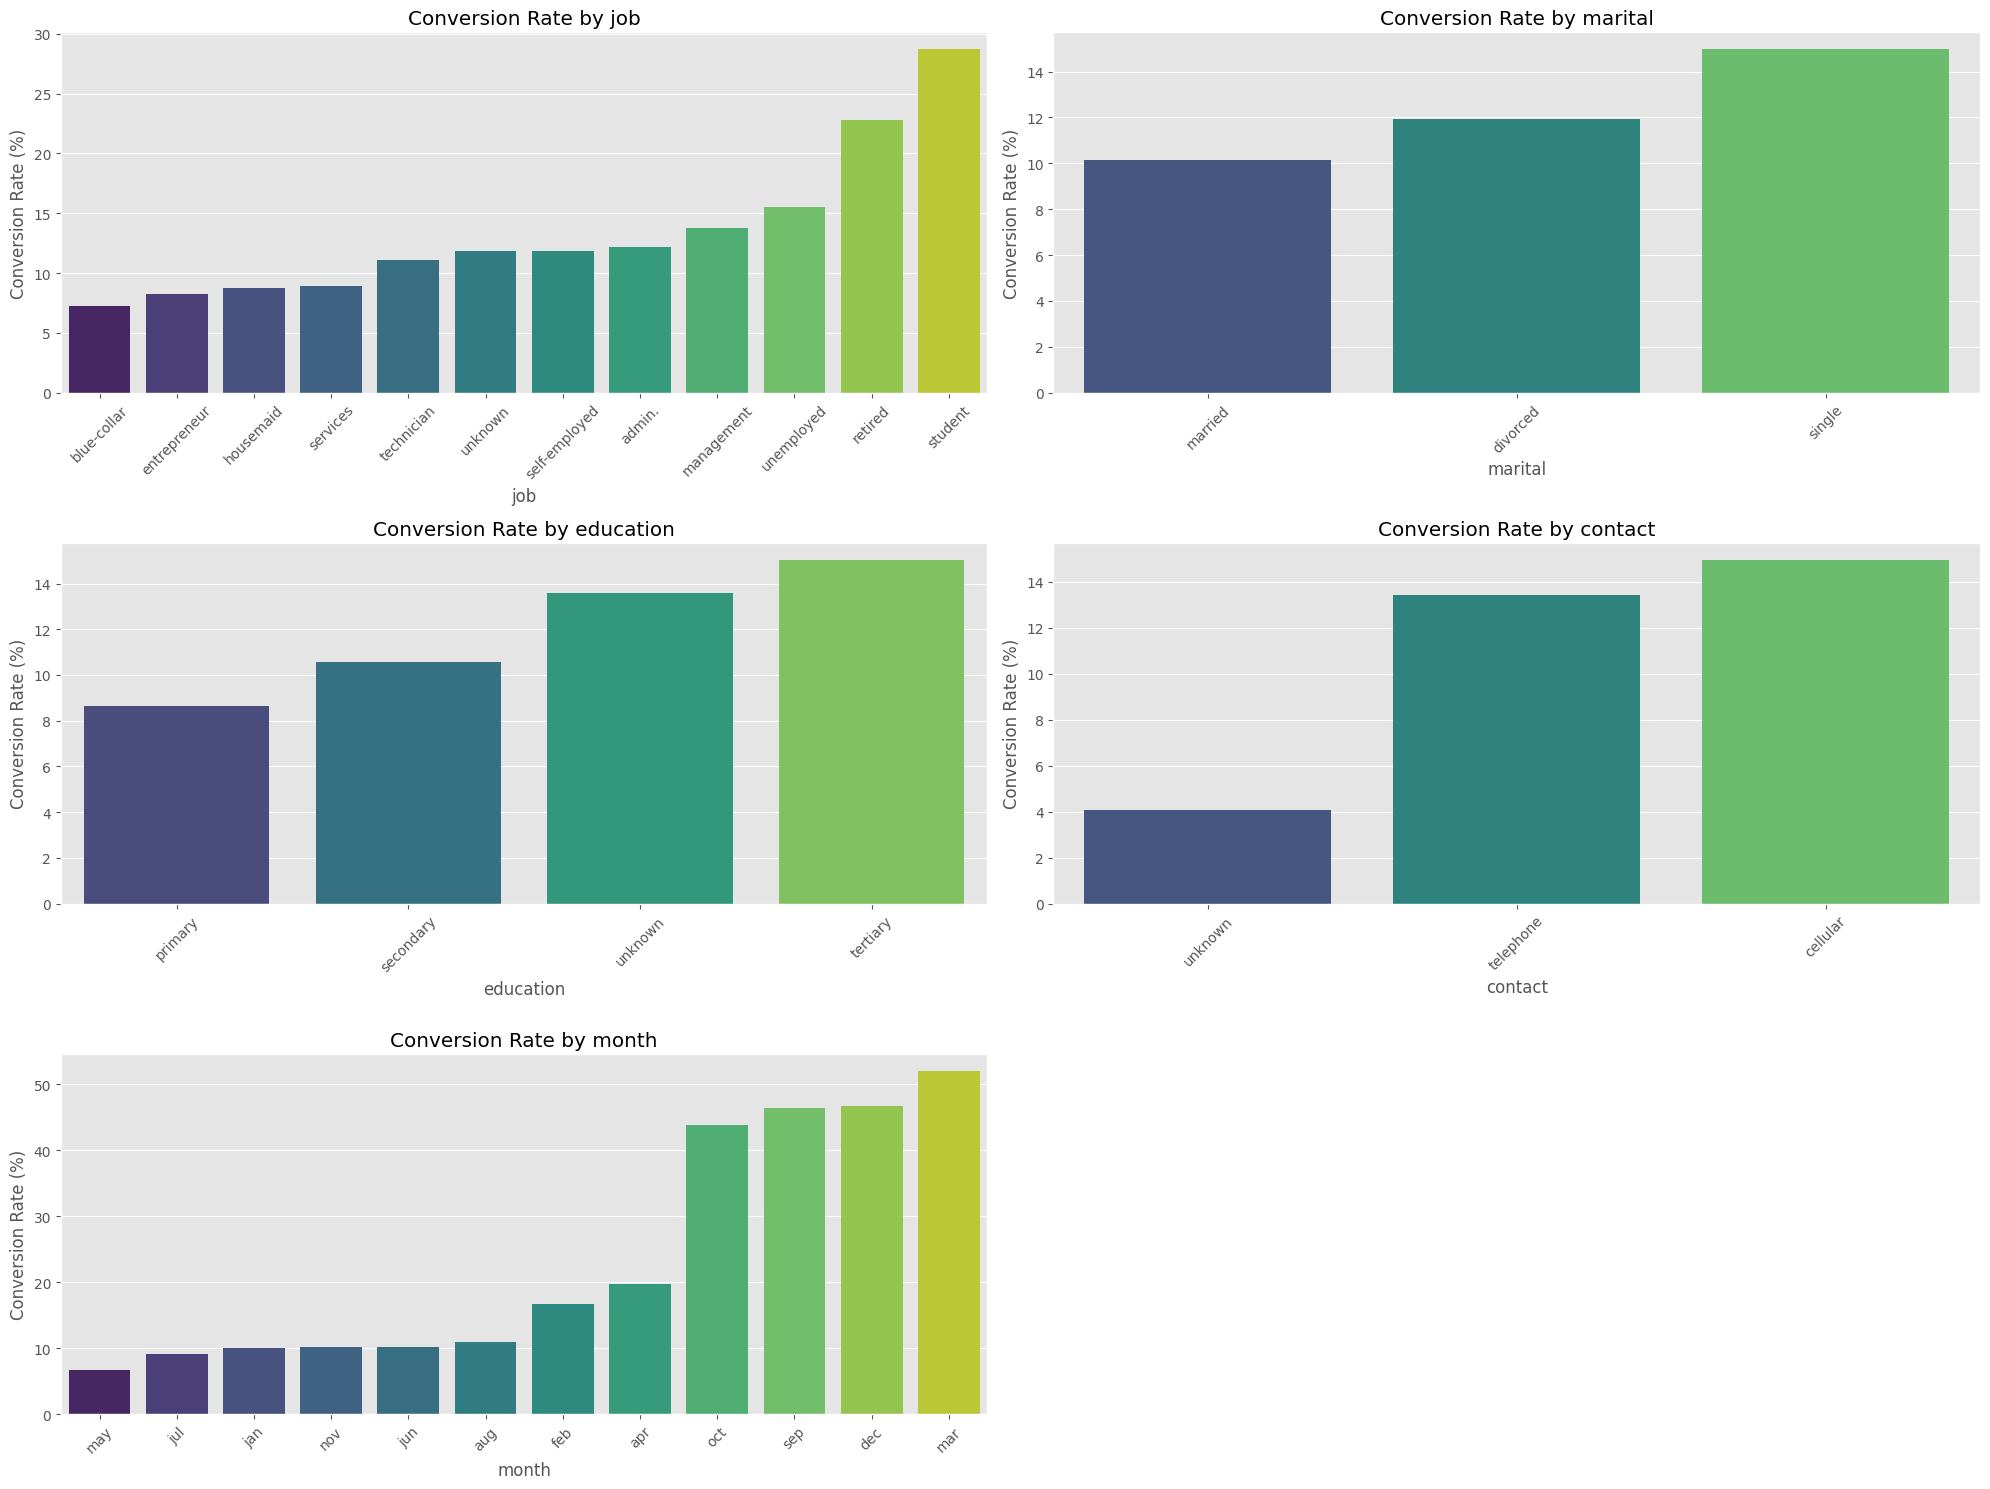

In [6]:
# Visualizing Categorical Features vs Target
categorical_cols = ['job', 'marital', 'education', 'contact', 'month']

plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    # Calculate conversion rate per category
    conversion_rate = data.groupby(col)['subscribe'].apply(lambda x: (x=='yes').sum() / len(x) * 100).sort_values()
    
    # Plot
    sns.barplot(x=conversion_rate.index, y=conversion_rate.values, palette='viridis')
    plt.title(f'Conversion Rate by {col}')
    plt.ylabel('Conversion Rate (%)')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

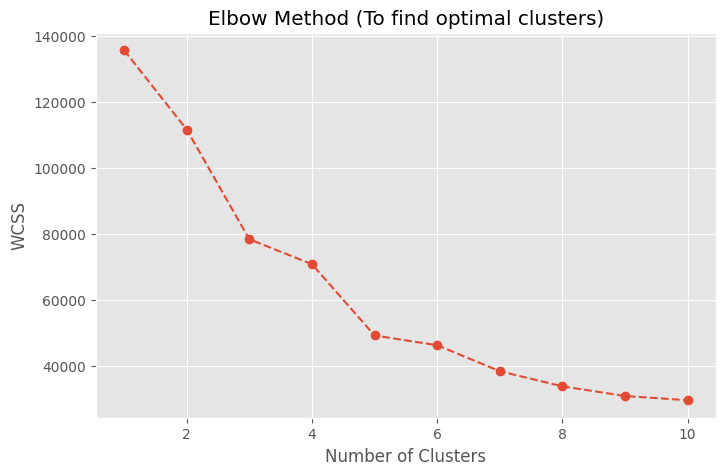

In [7]:
# Data Preparation for Clustering
# We will segment customers based on 'age', 'balance', and 'campaign' (behavior)
cluster_data = data[['age', 'balance', 'campaign']].copy()

# Scaling is important for K-Means
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# Elbow Method to find optimal number of clusters
wcss = [] # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method (To find optimal clusters)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Customer Segments Discovered:
   Cluster        age      balance   campaign  Conversion Rate (%)
0        0  34.027680   957.372741   1.921766            12.044796
1        1  52.539324  2129.444146   2.092752            13.000984
2        2  40.000000  1112.477199  21.197068             2.768730
3        3  40.385560  1043.475812   7.606980             6.185319


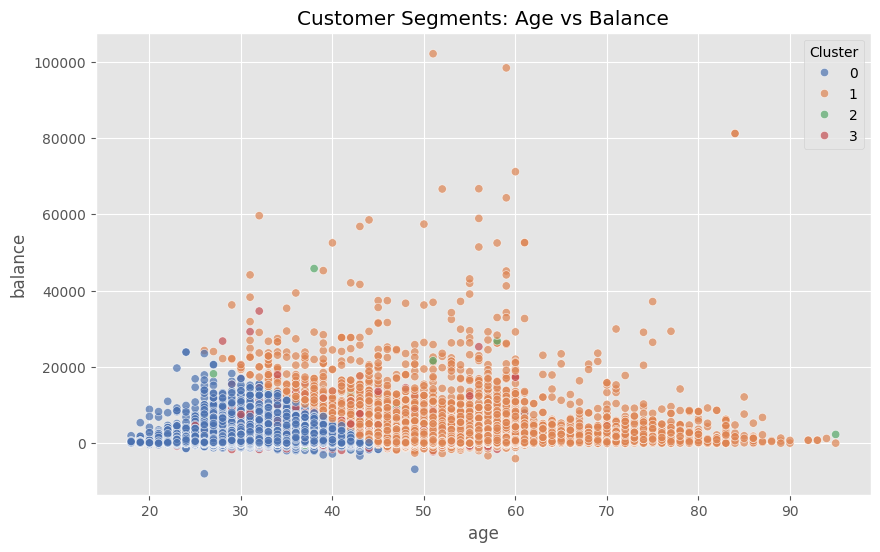

In [8]:
# Applying K-Means Clustering
# Let's assume optimal clusters = 4 (Based on Elbow Curve usually)
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(cluster_scaled)

# Analyze the Segments
cluster_analysis = data.groupby('Cluster')[['age', 'balance', 'campaign', 'subscribe']].agg({
    'age': 'mean',
    'balance': 'mean',
    'campaign': 'mean',
    'subscribe': lambda x: (x=='yes').sum() / len(x) * 100 # Conversion Rate
}).reset_index()

cluster_analysis.rename(columns={'subscribe': 'Conversion Rate (%)'}, inplace=True)
print("Customer Segments Discovered:")
print(cluster_analysis)

# Visualize Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='balance', hue='Cluster', data=data, palette='deep', alpha=0.7)
plt.title('Customer Segments: Age vs Balance')
plt.show()

In [9]:
# Preprocessing for Prediction
# Drop 'Cluster' column used for analysis, as we want to predict based on raw features
if 'Cluster' in data.columns:
    X = data.drop(['subscribe', 'Cluster'], axis=1)
else:
    X = data.drop('subscribe', axis=1)

y = data['subscribe'].apply(lambda x: 1 if x == 'yes' else 0)

# Convert Categorical variables to Dummy variables (One Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (36156, 41)
Testing Data Shape: (9039, 41)


In [10]:
# Handling Class Imbalance with SMOTE
from imblearn.over_sampling import SMOTE

print("Before SMOTE - 'Yes' counts:", sum(y_train == 1))
print("Before SMOTE - 'No' counts:", sum(y_train == 0))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE - 'Yes' counts:", sum(y_train_resampled == 1))
print("After SMOTE - 'No' counts:", sum(y_train_resampled == 0))
print("Data Balanced Successfully!")

Before SMOTE - 'Yes' counts: 4192
Before SMOTE - 'No' counts: 31964
After SMOTE - 'Yes' counts: 31964
After SMOTE - 'No' counts: 31964
Data Balanced Successfully!


Model Performance Report:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7942
           1       0.49      0.34      0.40      1097

    accuracy                           0.88      9039
   macro avg       0.70      0.65      0.67      9039
weighted avg       0.86      0.88      0.87      9039



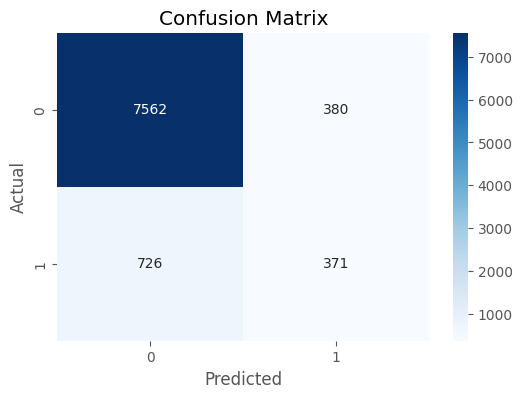

In [11]:
# Model Training & Evaluation

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on Balanced Data
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on Test Data
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
print("Model Performance Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

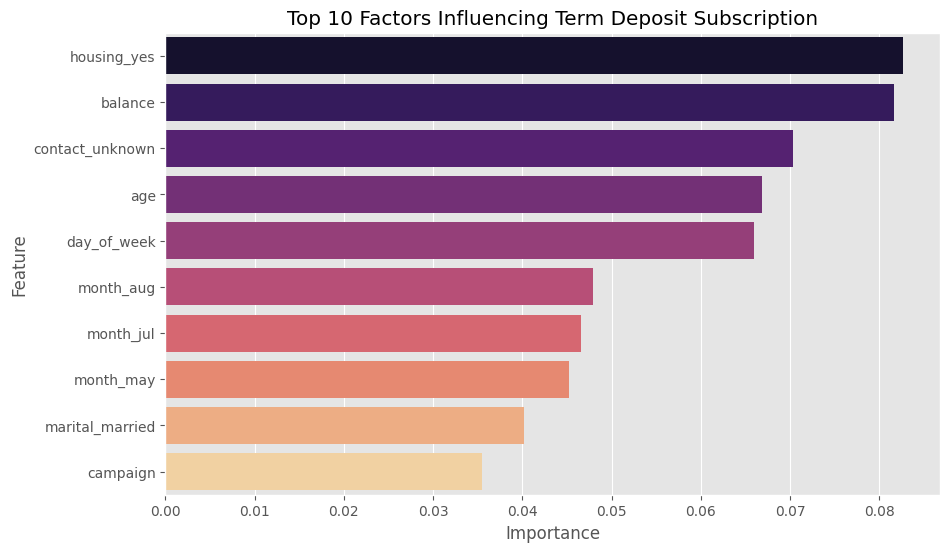

In [12]:
# Featuring Importance Plot
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Top 10 Factors Influencing Term Deposit Subscription')
plt.show()

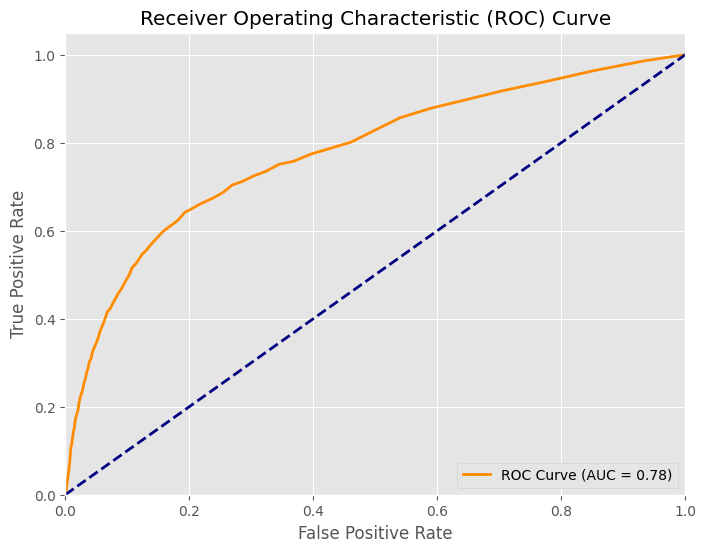

Model AUC Score: 0.78 (Closer to 1.0 is better)


In [13]:
# ROC-AUC Curve
from sklearn.metrics import roc_curve, auc

# Getting probability of 'Yes'
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculating ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotting ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Model AUC Score: {roc_auc:.2f} (Closer to 1.0 is better)")

In [14]:
# Saving Model for Deployment
import joblib

# Saving the model
joblib.dump(rf_model, 'bank_conversion_model.pkl')

# Save the columns used (important for future predictions)
model_columns = list(X.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("Model saved as 'bank_conversion_model.pkl'")
print("Model columns saved as 'model_columns.pkl'")

Model saved as 'bank_conversion_model.pkl'
Model columns saved as 'model_columns.pkl'


In [15]:
# Saving Final Data for Tableau Dashboard

# 1. Adding Cluster labels back to the original dataframe
data_for_export = data.copy()

# 2. Getting predictions for the whole dataset (not just test set)
# We need to preprocess the whole dataset exactly like we did for training
data_processed = pd.get_dummies(data_for_export.drop(['subscribe', 'Cluster'], axis=1), drop_first=True)

# Aligning columns (ensuring all columns from training exist here)
# If some columns are missing (e.g., a job type not present), fill with 0
for col in model_columns:
    if col not in data_processed.columns:
        data_processed[col] = 0
data_processed = data_processed[model_columns]

# Predicting Probabilities
data_for_export['Probability_to_Convert'] = rf_model.predict_proba(data_processed)[:, 1]

# 3. Creating a 'Target Group' label
# If probability > 0.6, we call them "High Potential"
data_for_export['Target_Label'] = data_for_export['Probability_to_Convert'].apply(lambda x: 'High Potential' if x > 0.6 else 'Low Potential')

# 4. Saving to CSV
data_for_export.to_csv('bank_marketing_final_with_predictions.csv', index=False)
print("Final file 'bank_marketing_final_with_predictions.csv' saved!")
print("Use this file in Tableau to visualize 'Target_Label' and 'Cluster'.")

Final file 'bank_marketing_final_with_predictions.csv' saved!
Use this file in Tableau to visualize 'Target_Label' and 'Cluster'.


In [16]:
# Saving Scaler and KMeans for the App
import joblib

# Saving the Scaler (Used for Segmentation)
joblib.dump(scaler, 'scaler.pkl')

# Saving the KMeans Model (Used for Segmentation)
joblib.dump(kmeans, 'kmeans.pkl')

print("All models (RandomForest, Scaler, KMeans) saved successfully!")

All models (RandomForest, Scaler, KMeans) saved successfully!


In [17]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

st.set_page_config(page_title="Bank Customer Prediction AI", layout="wide")

# 1. Loading the Saved Models
@st.cache_resource
def load_models():
    # Make sure these files are in the same folder
    rf_model = joblib.load('bank_conversion_model.pkl')
    model_columns = joblib.load('model_columns.pkl')
    scaler = joblib.load('scaler.pkl')
    kmeans = joblib.load('kmeans.pkl')
    return rf_model, model_columns, scaler, kmeans

# Loading models AFTER setting page config
rf_model, model_columns, scaler, kmeans = load_models()

# 2. App Title & Introduction
st.title("🏦 AI-Powered Bank Customer Segmentation & Prediction")
st.markdown("""
    **Welcome!** This tool helps bank managers decide:
    1.  **Prediction:** Will a customer subscribe to a Term Deposit? 
    2.  **Segmentation:** Which customer group do they belong to? (Targeting Strategy)
""")

# 3. Sidebar Inputs
st.sidebar.header("📝 Enter Customer Details")

# -- Numeric Inputs --
age = st.sidebar.slider("Age", 18, 95, 30)
balance = st.sidebar.number_input("Avg. Yearly Balance (€)", min_value=-5000, max_value=100000, value=1500)
day_of_week = st.sidebar.slider("Day of Month (1-31)", 1, 31, 15)
campaign = st.sidebar.slider("Number of Contacts (Campaign)", 1, 20, 1)
pdays = st.sidebar.number_input("Days since last contact (-1 if new)", value=-1)
previous = st.sidebar.number_input("Previous Contacts", value=0)

# -- Categorical Inputs --
job = st.sidebar.selectbox("Job Type", 
    ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 
     'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown'])

marital = st.sidebar.selectbox("Marital Status", ['married', 'divorced', 'single'])
education = st.sidebar.selectbox("Education Level", ['primary', 'secondary', 'tertiary', 'unknown'])
default = st.sidebar.selectbox("Has Credit in Default?", ['no', 'yes'])
housing = st.sidebar.selectbox("Has Housing Loan?", ['no', 'yes'])
loan = st.sidebar.selectbox("Has Personal Loan?", ['no', 'yes'])
contact = st.sidebar.selectbox("Contact Type", ['cellular', 'telephone', 'unknown'])
month = st.sidebar.selectbox("Last Contact Month", 
    ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
poutcome = st.sidebar.selectbox("Previous Campaign Outcome", ['unknown', 'failure', 'other', 'success'])

# 4. Processing Logic
def preprocess_input():
    input_df = pd.DataFrame(0, index=[0], columns=model_columns)
    
    input_df['age'] = age
    input_df['balance'] = balance
    input_df['day_of_week'] = day_of_week
    input_df['campaign'] = campaign
    input_df['pdays'] = pdays
    input_df['previous'] = previous
    
    cat_inputs = {
        'job': job, 'marital': marital, 'education': education, 
        'default': default, 'housing': housing, 'loan': loan,
        'contact': contact, 'month': month, 'poutcome': poutcome
    }
    
    for col, val in cat_inputs.items():
        dummy_name = f"{col}_{val}"
        if dummy_name in input_df.columns:
            input_df[dummy_name] = 1
            
    return input_df

# 5. Prediction & Results
if st.button("🚀 Analyze Customer"):
    user_data = preprocess_input()
    
    # -- Model 1: Prediction --
    pred_prob = rf_model.predict_proba(user_data)[0][1]
    
    # -- Model 2: Segmentation --
    segment_data = scaler.transform(user_data[['age', 'balance', 'campaign']])
    cluster_id = kmeans.predict(segment_data)[0]
    
    # -- Displaying Results --
    st.markdown("---")
    col1, col2 = st.columns(2)
    
    with col1:
        st.subheader("🔮 Prediction Result")
        if pred_prob > 0.5:
            st.success(f"**Likely to Subscribe! (YES)**")
            st.balloons()
        else:
            st.error(f"**Unlikely to Subscribe (NO)**")
        st.metric(label="Conversion Probability", value=f"{pred_prob:.1%}")
        
    with col2:
        st.subheader("🧩 Customer Segment")
        st.info(f"Customer belongs to **Cluster {cluster_id}**")
        
        if cluster_id == 0:
            st.write("👉 **Interpretation:** Likely a standard customer.")
        elif cluster_id == 1:
            st.write("👉 **Interpretation:** High Balance / Older Demographic (Good Target).")
        elif cluster_id == 2:
            st.write("👉 **Interpretation:** Low Balance / Younger Demographic.")
        else:
            st.write("👉 **Interpretation:** Targeted frequently in past campaigns.")

    st.markdown("---")
    st.caption("Developed by [Your Name]")

Overwriting app.py


In [18]:
%%writefile requirements.txt
pandas
numpy
scikit-learn
seaborn
matplotlib
streamlit
joblib
imbalanced-learn

Overwriting requirements.txt
